In [52]:
import pandas as pd
import numpy as np
import os
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt 
from math import isnan
import scipy.stats as ss
from scipy.optimize import minimize
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.ensemble import *
from sklearn.inspection import *
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.metrics import *
from sklearn import metrics
from sklearn.multioutput import *
from ngboost import NGBRegressor
from xgboost import XGBRegressor
import sklearn
import statistics
import warnings
warnings.filterwarnings("ignore")

def get_model_name(model):
    
    return model.__doc__.strip('\n').split('\n')[0].strip('.').strip(' ')


def get_cvmodel_res_error_chain(base_model, X_values, y_values, random_state = None, model_num = 200):
    
    rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=random_state)
    cvmodel_errors = pd.DataFrame()
    cvmodel_residuals = pd.DataFrame()
    for train, test in rkf.split(X_values):
        X_train, X_test = X_values.iloc[train], X_values.iloc[test]
        y_train, y_test = y_values.iloc[train], y_values.iloc[test]
        residuals, errors, _ = get_model_res_error_chain(base_model, X_train, y_train, X_test, y_test, model_num = model_num)
        cvmodel_residuals = pd.concat((cvmodel_residuals, residuals), axis=0)
        cvmodel_errors = pd.concat((cvmodel_errors, errors), axis=0)        

    return cvmodel_residuals.reset_index(drop = True), cvmodel_errors.reset_index(drop = True)

def nll_optimize(residuals, model_errors, number_of_bins = 20):
    
    def nll_cost(x):
        cost = 0
        for i in range(0, len(residuals)):
            cost += np.log(2 * np.pi) + np.log((x[0] * model_errors[i] + x[1]) ** 2) + (residuals[i]) ** 2 / (
                        x[0] * model_errors[i] + x[1]) ** 2
        return 0.5 * cost / len(residuals)

    x0 = np.array([1.0, 0.0])
    res = minimize(nll_cost, x0, method='nelder-mead')
    a = res.x[0]
    b = res.x[1]
    success = res.success
    if success is True:
        print("NLL optimization successful")
    else:
        print("NLL optimization failed")
    r_squared = calculate_rsquared(a, b, residuals, model_errors, number_of_bins=number_of_bins)
    
    return a, b, r_squared

def nll_calculate(residuals, model_errors):
    cost = 0
    for i in range(0, len(residuals)):
        cost += np.log(2 * np.pi) + np.log((model_errors[i]) ** 2) + (residuals[i]) ** 2 / (
                    model_errors[i]) ** 2
    return 0.5 * cost / len(residuals)
    
def calculate_rsquared(a, b, residuals, model_err, number_of_bins=20):
    model_errors = model_err * a + b
    abs_res = abs(residuals)

    # Set bins for calculating RMS
    upperbound = np.amax(model_errors)
    lowerbound = np.amin(model_errors)
    bins = np.linspace(lowerbound, upperbound, number_of_bins, endpoint=False)

    # Create a vector determining bin of each data point
    digitized = np.digitize(model_errors, bins)

    # Record which bins contain data (to avoid trying to do calculations on empty bins)
    bins_present = []
    for i in range(1, number_of_bins + 1):
        if i in digitized:
            bins_present.append(i)

    # Create array of weights based on counts in each bin
    weights = []
    for i in range(1,number_of_bins + 1):
        if i in digitized:
            weights.append(np.count_nonzero(digitized == i))

    # Calculate RMS of the absolute residuals
    RMS_abs_res = [np.sqrt((abs_res[digitized == bins_present[i]] ** 2).mean()) for i in range(0, len(bins_present))]

    # Set the x-values to the midpoint of each bin
    bin_width = bins[1]-bins[0]
    binned_model_errors = np.zeros(len(bins_present))
    for i in range(0, len(bins_present)):
        curr_bin = bins_present[i]
        binned_model_errors[i] = bins[curr_bin-1] + bin_width/2

    # Fit a line to the data
    model = LinearRegression(fit_intercept=True)
    model.fit(binned_model_errors[:, np.newaxis],
                  RMS_abs_res, sample_weight=weights)  #### : Can indicate subset of points to fit to using ":" --> "a:b"
    xfit = binned_model_errors
    yfit = model.predict(xfit[:, np.newaxis])

    # Calculate r^2 value
    r_squared = r2_score(RMS_abs_res, yfit, sample_weight=weights)
    # Calculate slope
    slope = model.coef_
    # Calculate y-intercept
    intercept = model.intercept_

    return r_squared

def plot_rve(residuals, model_errors, title = 'Data', save=False, file_name=None, number_of_bins=15):

    abs_res = abs(residuals)

    # check to see if number of bins should increase, and increase it if so
    model_errors_sorted = np.sort(model_errors)
    ninety_percentile = int(len(model_errors_sorted) * 0.9)
    ninety_percentile_range = model_errors_sorted[ninety_percentile] - np.amin(model_errors)
    total_range = np.amax(model_errors) - np.amin(model_errors)
    number_of_bins = number_of_bins
    if ninety_percentile_range / total_range < 5 / number_of_bins:
        number_of_bins = int(5 * total_range / ninety_percentile_range)

    # Set bins for calculating RMS
    upperbound = np.amax(model_errors)
    lowerbound = np.amin(model_errors)
    bins = np.linspace(lowerbound, upperbound, number_of_bins, endpoint=False)

    # Create a vector determining bin of each data point
    digitized = np.digitize(model_errors, bins)

    # Record which bins contain data (to avoid trying to do calculations on empty bins)
    bins_present = []
    for i in range(1, number_of_bins + 1):
        if i in digitized:
            bins_present.append(i)

    # Create array of weights based on counts in each bin
    weights = []
    for i in range(1, number_of_bins + 1):
        if i in digitized:
            weights.append(np.count_nonzero(digitized == i))

    # Calculate RMS of the absolute residuals
    RMS_abs_res = [np.sqrt((abs_res[digitized == bins_present[i]] ** 2).mean()) for i in
                   range(0, len(bins_present))]

    # Set the x-values to the midpoint of each bin
    bin_width = bins[1] - bins[0]
    binned_model_errors = np.zeros(len(bins_present))
    for i in range(0, len(bins_present)):
        curr_bin = bins_present[i]
        binned_model_errors[i] = bins[curr_bin - 1] + bin_width / 2

    # Fit a line to the data
    model = LinearRegression(fit_intercept=True)
    model.fit(binned_model_errors[:, np.newaxis],
              RMS_abs_res,
              sample_weight=weights)  #### SELF: Can indicate subset of points to fit to using ":" --> "a:b"
    xfit = binned_model_errors
    yfit = model.predict(xfit[:, np.newaxis])

    # Calculate r^2 value
    r_squared = r2_score(RMS_abs_res, yfit, sample_weight=weights)
    # Calculate slope
    slope = model.coef_
    # Calculate y-intercept
    intercept = model.intercept_

    # Create RvE plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Binned RvE Plot -- {}'.format(title))
    ax.set_xlabel('model error estimates / standard deviation')
    ax.set_ylabel('residuals / standard deviation')
    ax.plot(binned_model_errors, RMS_abs_res, 'o', color='blue')
    ax.plot(xfit, yfit)
    ax.text(0.04, 0.9, 'r^2 = %f' % (r_squared), transform=ax.transAxes)
    ax.text(0.04, 0.85, 'slope = %f' % (slope), transform=ax.transAxes)
    ax.text(0.04, 0.8, 'y-intercept = %f' % (intercept), transform=ax.transAxes)
    if save is False:
        plt.show()
    elif save is True:
        if file_name is None:
            print("save is set to True, but no file path specified")
        else:
            plt.savefig(file_name, dpi=300)
    plt.close(fig)
    
    return model_errors, abs_res, r_squared, slope, intercept, binned_model_errors, RMS_abs_res, xfit, yfit

def plot_rstat_overlay(residuals, unscaled_model_errors, scaled_model_errors, title = 'Data', save=False, file_name=None):
    
    # Eliminate model errors with value 0, so that the ratios can be calculated
    zero_indices = []
    for i in range(0, len(unscaled_model_errors)):
        if unscaled_model_errors[i] == 0:
            zero_indices.append(i)
    unscaled_residuals = np.delete(residuals, zero_indices)
    unscaled_model_errors = np.delete(unscaled_model_errors, zero_indices)
    #print("{} values deleted before making r-stat plot because unscaled model errors were zero.".format(len(zero_indices)))
    scaled_zero_indices = []
    for i in range(0, len(scaled_model_errors)):
        if scaled_model_errors[i] == 0:
            scaled_zero_indices.append(i)
    scaled_residuals = np.delete(residuals, scaled_zero_indices)
    scaled_model_errors = np.delete(scaled_model_errors, scaled_zero_indices)    
    nll_before, nll_after = nll_calculate(residuals, unscaled_model_errors), nll_calculate(residuals, scaled_model_errors)
    
    #print("{} values deleted before making r-stat plot because scaled model errors were zero.".format(len(zero_indices)))
    # make data for gaussian plot
    gaussian_x = np.linspace(-5, 5, 1000)
    # create plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('{}, Raw NLL {:.2f}, Cal NLL {:.2f}'.format(title, nll_before, nll_after))
    ax.set_xlabel(r'residuals / $\hat{\sigma}$')
    ax.set_ylabel('relative counts')
    ax.hist(unscaled_residuals / unscaled_model_errors, bins=30, color='grey', edgecolor='black', density=True, alpha=0.5, label='uncalibrated')
    ax.hist(scaled_residuals / scaled_model_errors, bins=30, color='blue', edgecolor='black', density=True, alpha=0.5, label='calibrated')
    ax.plot(gaussian_x, ss.norm.pdf(gaussian_x, 0, 1), label='standard normal pdf', color='orange')
    ax.legend(loc="upper left")
    #ax.text(0.05, 0.9, 'mean = %.3f' % (np.mean(residuals / model_errors)), transform=ax.transAxes)
    #ax.text(0.05, 0.85, 'std = %.3f' % (np.std(residuals / model_errors)), transform=ax.transAxes)
    if save is False:
        plt.show()
    elif save is True:
        if file_name is None:
            print("save is set to True, but no file path specified")
        else:
            plt.savefig(file_name, dpi=300)
    plt.close(fig)
    # print("r-statistic:")
    # print("uncalibrated mean = %.3f" % (np.mean(unscaled_residuals / unscaled_model_errors)))
    # print("uncalibrated stdev = %.3f" % (np.std(unscaled_residuals / unscaled_model_errors)))
    # print("calibrated mean = %.3f" % (np.mean(scaled_residuals / scaled_model_errors)))
    # print("calibrated stdev = %.3f" % (np.std(scaled_residuals / scaled_model_errors)))

# 1. Load Data

In [5]:
data = pd.read_csv('energy.csv', index_col = 0).dropna()
X = data.iloc[:,:-2]
y = data.iloc[:,-2:]

rstate = 982
n_models = 100
rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=rstate)

# 2. Bagging Model

In [44]:
base_model = RandomForestRegressor(n_estimators = n_models, max_depth=None, min_samples_split=2, min_samples_leaf=2)
#base_model = NGBRegressor(n_estimators = n_models,learning_rate=0.02, verbose = False)
#base_model = GradientBoostingRegressor(n_estimators = n_models)
#base_model = LinearRegression()
#model = MLPRegressor(hidden_layer_sizes=(4,), activation='relu', solver='adam', alpha=0.01, learning_rate='adaptive')
model = RegressorChain(base_model)

### Model Optimization

In [7]:
predictions = pd.DataFrame()
truth = pd.DataFrame()
for train, test in rkf.split(X):

    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    model = RegressorChain(base_model)
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    predictions = pd.concat((predictions, pd.DataFrame(test_predictions)), axis=0)
    truth = pd.concat((truth, y_test), axis=0)
    
print(np.sqrt(mean_squared_error(truth, predictions)))

1.5702119570422366


In [85]:
def get_model_res_error_chain(model, X_train, y_train, X_test, y_test, model_num = 200):  
    
    #examples to test the order of estimators pools
    #model.estimators_[0].estimators_[1].predict(pd.concat((X_test.reset_index(drop = True),pd.DataFrame(test_predictions[:,:0])),axis = 1)).shape
    
    #only tree-based model is allowed
    model_name = get_model_name(model)
    model.fit(X_train, y_train)
    
    #model predictions and residuals
    predictions = model.predict(X_test)
    residuals = y_test - predictions
    
    #model standard errors by concatenating all targets
    errors = pd.DataFrame()
    for k in range(len(model.estimators_)):
        #X_test for the current chain, note that numpy array is preferred at this moment during pandas concatenation
        Xc_test = pd.concat((X_test.reset_index(drop = True),pd.DataFrame(predictions[:,:k])),axis = 1) 
        if ('NGBoost' in model_name):
            err = pd.Series(model.estimators_[k].pred_dist(Xc_test).scale)
        else:    
            err = []
            preds = []       
            for pred in model.estimators_[k].estimators_:
                if 'Gradient Boosting' in model_name:
                    preds.append(pred[0].predict(Xc_test))
                else:
                    preds.append(pred.predict(Xc_test))

            err = pd.Series(np.array(preds).std(axis = 0, ddof = 1), index = residuals.index)
        
        errors = pd.concat((errors, err), axis = 1)
    
    errors.columns = y_test.columns
    predictions = pd.DataFrame(predictions, columns = y_test.columns)
    
    #all dataframes
    return residuals, errors, predictions

### Algorithm Test

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
res, err, _ = get_model_res_error_chain(model, X_train, y_train, X_test, y_test, model_num = n_models)

In [84]:
cvres, cverr = get_cvmodel_res_error_chain(model, X, y, random_state = rstate, model_num = n_models)

# 3. Uncertainty Prediction

In [86]:
unscaled_model_errors = pd.DataFrame()
scaled_model_errors = pd.DataFrame()
residuals = pd.DataFrame()
predictions = pd.DataFrame()
truth = pd.DataFrame()

for train, test in tqdm(rkf.split(X)):   
    
    unscaled_model_errors_1tg = []
    scaled_model_errors_1tg = []
    residuals_1tg = []
    predictions_1tg = []
    
    # Get CV model residuals and errors
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    cv_residuals, cv_model_errors = get_cvmodel_res_error_chain(model, X_train, y_train, random_state = rstate, model_num = n_models)
    
    # Scale residuals and model errors by data standard deviation
    stdev = np.std(y_train)
    cv_residuals = cv_residuals / stdev
    cv_model_errors = cv_model_errors / stdev
    
    # Predictions
    res_all, err_all, pred_all = get_model_res_error_chain(model, X_train, y_train, X_test, y_test, model_num = n_models)
    
    # get results for individual targets
    for k in range(y.shape[1]):
        
        # calibration for individual targets
        a, b, r_squared = nll_optimize(cv_residuals.iloc[:,k], cv_model_errors.iloc[:,k])

        # Get test data residuals and model errors and scale them
        test_residuals, test_model_errors, test_predictions = res_all.iloc[:,k], err_all.iloc[:,k], pred_all.iloc[:,k]
        test_residuals = test_residuals / stdev.iloc[k]
        test_model_errors = test_model_errors / stdev.iloc[k]

        # calibrate model errors using scale factors obtained above
        test_model_errors_scaled = test_model_errors * a + b
        
        # Append results from this split to the arrays to be returned
        unscaled_model_errors_1tg.append(test_model_errors)
        scaled_model_errors_1tg.append(test_model_errors_scaled)
        residuals_1tg.append(test_residuals)
        predictions_1tg.append(test_predictions)

    unscaled_model_errors = pd.concat((unscaled_model_errors, pd.DataFrame(unscaled_model_errors_1tg).transpose()), axis = 0)
    scaled_model_errors = pd.concat((scaled_model_errors, pd.DataFrame(scaled_model_errors_1tg).transpose()), axis = 0)
    residuals = pd.concat((residuals, pd.DataFrame(residuals_1tg).transpose()), axis = 0)
    predictions = pd.concat((predictions, pd.DataFrame(predictions_1tg).transpose()), axis = 0)
    truth = pd.concat((truth, y_test), axis = 0)

unscaled_model_errors.reset_index(drop = True, inplace = True)
scaled_model_errors.reset_index(drop = True, inplace = True)
residuals.reset_index(drop = True, inplace = True)
predictions.reset_index(drop = True, inplace = True)
truth.reset_index(drop = True, inplace = True)
#nll_before, nll_after = nll_calculate(residuals, unscaled_model_errors), nll_calculate(residuals, scaled_model_errors)

0it [00:00, ?it/s]

NLL optimization successful


1it [00:05,  5.74s/it]

NLL optimization successful
NLL optimization successful


2it [00:11,  5.55s/it]

NLL optimization successful
NLL optimization successful


3it [00:16,  5.66s/it]

NLL optimization successful
NLL optimization successful


4it [00:22,  5.63s/it]

NLL optimization successful
NLL optimization successful


5it [00:28,  5.62s/it]

NLL optimization successful


In [87]:
ic = 0
nll_before, nll_after = nll_calculate(residuals.iloc[:,ic], unscaled_model_errors.iloc[:,ic]), nll_calculate(residuals.iloc[:,ic], scaled_model_errors.iloc[:,ic])

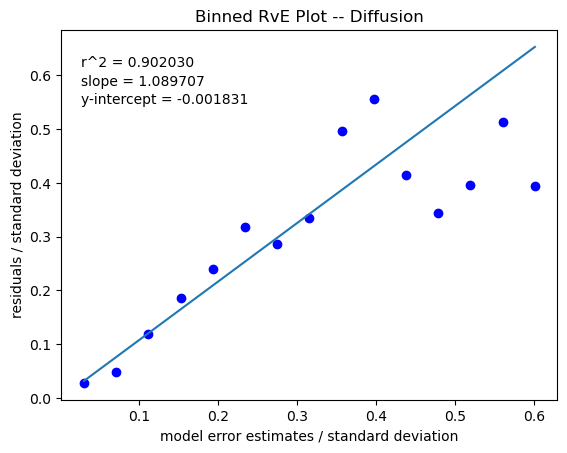

In [89]:
plot_rve(residuals.iloc[:,ic], scaled_model_errors.iloc[:,ic], 'Diffusion');

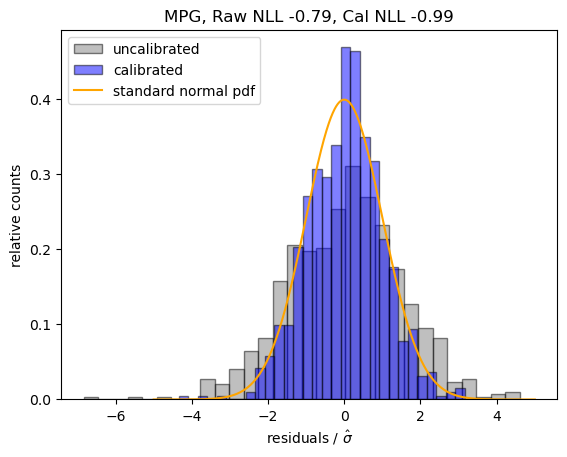

In [90]:
plot_rstat_overlay(residuals.iloc[:,ic], unscaled_model_errors.iloc[:,ic], scaled_model_errors.iloc[:,ic], 'MPG')

<ErrorbarContainer object of 3 artists>

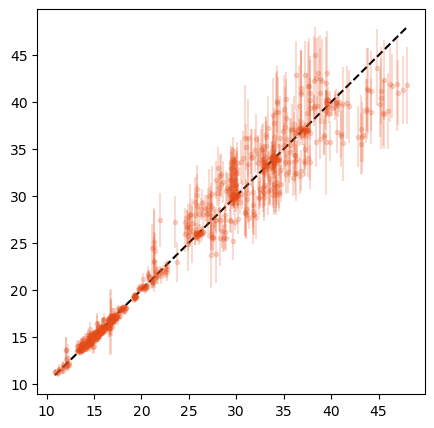

In [101]:
ic = 0
plt.figure(figsize = (5,5))
plt.plot([truth.iloc[:,ic].min(),truth.iloc[:,ic].max()],[truth.iloc[:,ic].min(),truth.iloc[:,ic].max()],'k--')
plt.errorbar(x = truth.iloc[:,ic], y = predictions.iloc[:,ic], yerr = scaled_model_errors.iloc[:,ic] * stdev.iloc[ic], fmt = '.', color = (0.9,0.3,0.1), alpha = 0.2)

In [ ]:
y

,Cooling Load,Heating Load
0,21.33,15.55
1,21.33,15.55
2,21.33,15.55
3,21.33,15.55
4,28.28,20.84
...,...,...
763,21.40,17.88
764,16.88,16.54
765,17.11,16.44
766,16.61,16.48
